# 202210xx 组会 NLP预训练与下游任务代码实现
  文档主要内容是我在入门nlp时所遇到的一些代码上的问题，积累总结下来成为文档。主要解决的是：

  1. 训练自己的数据集
  2. 在深度学习看源码的时候常常看到有很多util和包，让我不能理解。在查阅资料后得知在dl实验过程中基本需要三个部分，分别为dataloader、trainer、model。其中model根据不同论文中的实现不一样内容也大不一样。但是dataloader和trainer大多都是一个流程。所以在第一部分简单的进行了实现，也理解了整个训练的流程。
  3. 一开始对于单词为什么要预训练和得到的模型可以找到单词的相似单词这个结论只是看书觉得有些抽象，不知道数据的内容和形状。所以我也进行了简单的实现，本文只实现了word2vector和bert两个方式的预训练。
  4. 下游任务的实现（但是只是简单的demo）

  当前文档主要包含了以下内容：
  - lstm实现情感分析
   - 基础案例
   - dataloader
   - trainer
  - 预训练（word2vector和bert预训练实现）
   - word2vector实现
   - bert实现
  - nlp下游任务实现
   - glove微调lstm实现情感分析
   - bert微调实现语义推断

  

In [ ]:
# 让当前笔记本挂载Google云硬盘
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# 如果不在colab实现，则不运行当前单元格
!cp drive/MyDrive/train.csv train.csv

## lstm实现情感分析

### 基础案例

In [1]:
# 导包
import torch
import torch.nn as nn
import torch.optim as optim
import collections
import torch.utils.data as Data
from torch.autograd import Variable
import jieba
import pandas as pd
import numpy as np
!pip install d2l==0.17.1
!pip install matplotlib==3.0.0
from d2l import torch as d2l

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 82 kB 559 kB/s 
     |████████████████████████████████| 61 kB 7.5 MB/s 
     |████████████████████████████████| 20.1 MB 1.2 MB/s 
     |████████████████████████████████| 11.6 MB 56.2 MB/s 
     |████████████████████████████████| 9.9 MB 56.4 MB/s 
     |████████████████████████████████| 120 kB 51.2 MB/s 
     |████████████████████████████████| 1.6 MB 49.4 MB/s 
     |████████████████████████████████| 82 kB 510 kB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: pandas
    Found existing installation: pandas 1.3.5
    Uninstalling pandas-1.3.5:
      Successfully u

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 12.8 MB 4.8 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.3.3
    Uninstalling matplotlib-3.3.3:
      Successfully uninstalled matplotlib-3.3.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.5 requires matplotlib!=3.0.0,>=2.0.2, but you have matplotlib 3.0.0 which is incompatible.
scikit-image 0.18.3 requires matplotlib!=3.0.0,>=2.0.0, but you have matplotlib 3.0.0 which is incompatible.
plotnine 0.8.0 requires matplotlib>=3.1.1, but you have matplotlib 3.0.0 which is incompatible.
plotnine 0.8.0 requires numpy>=1.19.0, but you have numpy 1.18.5 which is incompatible.
mizani 0.7.3 requires matplotlib>=3.1.1, but you have matplotlib 3.0.0 which is incompatible.
d2l 0.17

In [ ]:
# 数据
from google.colab import data_table
from vega_datasets import data
# colab 插件 开启 datatable
data_table.enable_dataframe_formatter()

df = pd.read_csv("train.csv")
df = df.sample(frac=1)
df[:10]

,label,review
194,0,看到网友的点评还有些不信，去了以后才知道什么叫全世界最脏，最差的酒店。
233,0,"这酒店太旧了,大厅看上去还可以.房间的设施成旧不堪!卫生间的马桶真的都不走水的.早餐太一般了..."
662,1,"因为这里有免费的宽带,才预定了豪华单人大床房...下面是我的一些优缺点评价:优点:1.环境不..."
415,1,7月25日到家人到泰山玩，通过携程订的华侨大厦的房间（说是搞活动，花280升级到360的房间...
57,0,"整个房间也太小了点,所有的加一起大概才十平米左右!床单是脏的."
32,0,1酒店比较偏打车不方便2酒店楼上有KTV，晚上非常吵，特别是对住在五楼的房客。3前台接待，态...
68,0,鞋撑在云南的协议酒店少得可怜，应该下大力气多做些工作，把如家的店子也到处开一开，要不然我们这...
70,0,携程服务人员电话中向我推荐了此家酒店，向我说明这是四星酒店，客户评价都很好。住进去之后，很疑...
459,1,酒店服务意识很好，很热情，主动介绍酒店的特色。感觉不错。
88,0,住的房间靠近马路，比较吵。房间有股味道。不如锦江干净。不推荐入住，早饭还可以。


In [ ]:
# 转为数组
seq = df["review"].tolist()
label = df["label"].tolist()
display(seq[:3])
display(label[:3])

#分词
seq_cut = []
seq_cut_list = []
for i in seq:
    cut_res = list(jieba.cut(i))
    # 收集每次出现的单词
    seq_cut = seq_cut + cut_res
    # 收集每次出现的句子
    seq_cut_list.append(cut_res)
word2num = sorted(collections.Counter(seq_cut).items(), key=lambda item: item[1], reverse=True)
# 所有词
vocab = list(set(seq_cut))
# 词对应索引
word2index = {w[0]: i+1 for i, w in enumerate(word2num)}
word2index["PAD"] = 0

['看到网友的点评还有些不信，去了以后才知道什么叫全世界最脏，最差的酒店。',
 '这酒店太旧了,大厅看上去还可以.房间的设施成旧不堪!卫生间的马桶真的都不走水的.早餐太一般了.要去入住的朋友要有思想准备,期望值不要太高.400多一晚说实话不太值!!',
 '因为这里有免费的宽带,才预定了豪华单人大床房...下面是我的一些优缺点评价:优点:1.环境不错,别墅型的房子..到处种的椰子树..一个大游泳池.2.地里位置不错,属于市中心..2分钟路程一个大型超市(对于本地来说),..3分钟路程吃饭的地方很方便,走路2分钟不到就有水果市场..晚上周围的马路上也相当热闹3.房间还算干净..4.有早餐,随便对付一下应该是没有问题的...缺点:1.房间比较小,热水好像是有时间才有的..因为我下午洗澡一般都没有热水2.晚上上网的速度跟牛一样,根本打不开网页..不知道什么原因...问服务台,回答是"我们也是这样的"总体来说,200多的房价对于这样的酒店算是还可以了...我们出门总不能要求酒店就跟自己的家一样..再说了就是在家你可能也有时候会抱怨卫生间有味道,厨房太小..我们出来了总是随遇而安吧...祝大家旅程愉快..']

[0, 0, 1]

Building prefix dict from the default dictionary ...
DEBUG:jieba:Building prefix dict from the default dictionary ...
Dumping model to file cache /tmp/jieba.cache
DEBUG:jieba:Dumping model to file cache /tmp/jieba.cache
Loading model cost 0.816 seconds.
DEBUG:jieba:Loading model cost 0.816 seconds.
Prefix dict has been built successfully.
DEBUG:jieba:Prefix dict has been built successfully.


In [ ]:
# 词典大小
vocab_size = len(word2index)
# 句子最大长度
seq_length = max([len(i) for i in seq_cut_list])
embed_size = 3
num_classes = 2
num_hiddens = 5

In [ ]:
def prepare_data(seq,label):
    inputs = []
    for i in seq:
        seq_index = [word2index[word] for word in i]
        # 句子长度补齐
        if len(seq_index)!=seq_length:
            seq_index = seq_index + [0] * (seq_length-len(seq_index))
        inputs.append(seq_index)
    targets = [i for i in label]
    return inputs, targets
input_batch_old,target_batch_old = prepare_data(seq_cut_list,label)
input_batch,target_batch = Variable(torch.LongTensor(input_batch_old)),Variable(torch.LongTensor(target_batch_old))

In [ ]:
def try_gpu(i=0):
    """Return gpu(i) if exists, otherwise return cpu()."""
    if torch.cuda.device_count() >= i + 1:
        return torch.device(f'cuda:{i}')
    return torch.device('cpu')
device = try_gpu()
device

device(type='cuda', index=0)

In [ ]:
class BiLSTM(nn.Module):
    def __init__(self, **kwargs):
        super(BiLSTM, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        # 将bidirectional设置为True以获取双向循环神经⽹络
        self.encoder = nn.LSTM(embed_size, num_hiddens, num_layers=2,bidirectional=True)
        self.decoder = nn.Linear(4 * num_hiddens, 2)
    def forward(self, inputs):
        # inputs的形状是（批量⼤⼩，时间步数）
        # 因为⻓短期记忆⽹络要求其输⼊的第⼀个维度是时间维，
        # 所以在获得词元表⽰之前，输⼊会被转置。
        # 输出形状为（时间步数，批量⼤⼩，词向量维度）
        embeddings = self.embedding(inputs.T)
        self.encoder.flatten_parameters()
        # 返回上⼀个隐藏层在不同时间步的隐状态，
        # outputs的形状是（时间步数，批量⼤⼩，2*隐藏单元数）
        outputs, _ = self.encoder(embeddings)
        # 连结初始和最终时间步的隐状态，作为全连接层的输⼊，
        # 其形状为（批量⼤⼩，4*隐藏单元数）
        encoding = torch.cat((outputs[0], outputs[-1]), dim=1)
        outs = self.decoder(encoding)
        return outs

In [ ]:
net = BiLSTM()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
X = input_batch.to(device)
net.to(device)
Y = target_batch.to(device)

In [ ]:
# 训练
for epoch in range(1000):
    net.train()
    pred = net(X)
    loss = criterion(pred, Y)
    if (epoch+1)%200==0:
      print('Epoch:', '%04d' % (epoch + 1), 'loss =', '{:.6f}'.format(loss))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

Epoch: 0200 loss = 0.302109
Epoch: 0400 loss = 0.089808
Epoch: 0600 loss = 0.049415
Epoch: 0800 loss = 0.018903
Epoch: 1000 loss = 0.007632


### dataloader&trainer构建

#### dataloader

In [ ]:
import random

In [ ]:
def seq_data_iter_sequential(train, label, batch_size, num_steps=1):
    """使⽤顺序分区⽣成⼀个⼩批量⼦序列"""
    # 从随机偏移量开始划分序列
    item_len = len(train[0])

    num_tokens = (len(train) // batch_size) * batch_size
    Xs = torch.tensor(train[:num_tokens])
    Ys = torch.tensor(label[:num_tokens])

    Xs, Ys = Xs.reshape(-1, batch_size, item_len), Ys.reshape(-1,batch_size)
    num_batches = Xs.shape[0] // num_steps
    for i in range(0, num_steps * num_batches, num_steps):
        X = Xs[i]
        Y = Ys[i]
        yield X, Y

In [ ]:
# seq_data_iter_sequential 使用demo
test_train_seq = []
for i in range(35):
  test_train_seq.append(list(range(i*20,(i+1)*20)))

test_label_seq = list(range(0,35))
for i,j in seq_data_iter_sequential(test_train_seq,test_label_seq,3):
  print("x:",i,"\ny:",j)
  break

x: tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 19],
        [20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37,
         38, 39],
        [40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57,
         58, 59]]) 
y: tensor([0, 1, 2])


In [ ]:
# loader类
class DataLoader:
    """An iterator to load sequence data."""
    def __init__(self, batch_size, num_steps=1):
        self.data_iter_fn = seq_data_iter_sequential
        self.train_data, self.train_label = input_batch_old, target_batch_old
        self.batch_size = batch_size
        self.num_batches = len(self.train_data) // batch_size

    def __iter__(self):
        return self.data_iter_fn(self.train_data, self.train_label, self.batch_size)

In [ ]:
# load方法
def load_data(batch_size):
  """返回数据集的迭代器"""
  data_iter = DataLoader(batch_size)
  return data_iter

#### trainer

In [ ]:
batch_size = 64
train_iter = load_data(batch_size)
for x,y in train_iter:
  print("每个batch数据的内容")
  display("X:",x,"Y:",y)
  break

每个batch数据的内容


'X:'

tensor([[ 315, 1127,    2,  ...,    0,    0,    0],
        [  93,    6,  991,  ...,    0,    0,    0],
        [  97,  145,   19,  ...,    0,    0,    0],
        ...,
        [  56, 1749,  654,  ...,    0,    0,    0],
        [  65,   31,    2,  ...,    0,    0,    0],
        [  16,  325,   52,  ...,    0,    0,    0]])

'Y:'

tensor([0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0,
        1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0,
        0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0])

In [ ]:
def accuracy(y_hat, y):
  """Compute the number of correct predictions."""
  if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
      y_hat = argmax(y_hat, axis=1)
  cmp = astype(y_hat, y.dtype) == y
  return float(reduce_sum(astype(cmp, y.dtype)))

def train_one_batch(net,x,y,loss,trainer,device):
  x = x.to(device)
  y = y.to(device)

  trainer.zero_grad()
  pred = net(x)
  l = loss(pred, y)
  l.sum().backward()
  trainer.step()
  train_loss_sum = l.sum()
  train_acc_sum = accuracy(pred, y)
  return train_loss_sum, train_acc_sum

argmax = lambda x, *args, **kwargs: x.argmax(*args, **kwargs)
astype = lambda x, *args, **kwargs: x.type(*args, **kwargs)
reduce_sum = lambda x, *args, **kwargs: x.sum(*args, **kwargs)

In [ ]:
def train(net, train_iter, test_iter, loss, trainer, num_epochs,device):
    """Train a model with GPU"""
    num_batches = train_iter.num_batches
    net.to(device)
    net.train()

    for epoch in range(num_epochs):
        # Sum of training loss, sum of training accuracy, no. of examples,
        # no. of predictions
        for i, (features, labels) in enumerate(train_iter):
            l, acc = train_one_batch(net, features, labels, loss, trainer,device)
            if (i + 1) % (num_batches) == 0 or i == num_batches - 1:
                print("epoch:",epoch,"acc:",acc,"loss",l)
    # print(f'loss {metric[0] / metric[2]:.3f}, train acc '
    #       f'{metric[1] / metric[3]:.3f}, test acc {test_acc:.3f}')
    # print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec on '
    #       f'{str(devices)}')

In [ ]:
lr, num_epochs = 0.01, 20
net = BiLSTM()
optimizer = optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction="none")
train(net,train_iter,0,loss,optimizer,num_epochs,device)

epoch: 0 acc: 28.0 loss tensor(44.5319, device='cuda:0', grad_fn=<SumBackward0>)
epoch: 1 acc: 39.0 loss tensor(44.2170, device='cuda:0', grad_fn=<SumBackward0>)
epoch: 2 acc: 40.0 loss tensor(43.3062, device='cuda:0', grad_fn=<SumBackward0>)
epoch: 3 acc: 44.0 loss tensor(39.2422, device='cuda:0', grad_fn=<SumBackward0>)
epoch: 4 acc: 45.0 loss tensor(36.0559, device='cuda:0', grad_fn=<SumBackward0>)
epoch: 5 acc: 45.0 loss tensor(33.6071, device='cuda:0', grad_fn=<SumBackward0>)
epoch: 6 acc: 51.0 loss tensor(28.7657, device='cuda:0', grad_fn=<SumBackward0>)
epoch: 7 acc: 48.0 loss tensor(32.8570, device='cuda:0', grad_fn=<SumBackward0>)
epoch: 8 acc: 57.0 loss tensor(20.5080, device='cuda:0', grad_fn=<SumBackward0>)
epoch: 9 acc: 58.0 loss tensor(18.3792, device='cuda:0', grad_fn=<SumBackward0>)
epoch: 10 acc: 58.0 loss tensor(18.3021, device='cuda:0', grad_fn=<SumBackward0>)
epoch: 11 acc: 59.0 loss tensor(15.5606, device='cuda:0', grad_fn=<SumBackward0>)
epoch: 12 acc: 59.0 loss t

## 预训练（word2vector和bert）

### word2vector
skip-gram
<div align=center> 
<img src="https://aweidao1.com/image/thumb/2022-09-22/1663852754249744PKvhqY9L.png" width="60%"/>
</div>

cbow
<div align=center> 
<img src="https://aweidao1.com/image/thumb/2022-09-22/1663852776354795QV04IncU.png" width="60%"/>
</div>

任务可视化

可以知道的是在skip-gram里，我们需要的是将center词做输入，预测上下文词，是一个多分类任务，类别数是词典的上下文大小。
<div align = center>
<img src="https://aweidao1.com/image/thumb/2022-09-22/1663853672009861TxJ5WEC2.png"/>
</div>

cbow同理，上下文预测中心词，分类数为词典的大小。

In [ ]:
import math
import os
import random
import torch
from d2l import torch as d2l

In [ ]:
d2l.DATA_HUB['ptb'] = (d2l.DATA_URL + 'ptb.zip',
'319d85e578af0cdc590547f26231e4e31cdf1e42')

def read_ptb():
  """将PTB数据集加载到⽂本⾏的列表中"""
  data_dir = d2l.download_extract('ptb')
  # Readthetrainingset.
  with open(os.path.join(data_dir, 'ptb.train.txt')) as f:
    raw_text = f.read()
  return [line.split() for line in raw_text.split('\n')]
sentences = read_ptb()
f'# sentences数: {len(sentences)}'

'# sentences数: 42069'

In [ ]:
vocab = d2l.Vocab(sentences, min_freq=10)
f'vocab size: {len(vocab)}'

'vocab size: 6719'

#### 下采样
针对没有太多意义的高频词汇使用下采样降低出现次数，公式如下

$$ P(w_i) = max(1-\sqrt{t\over f(w_i)},0). $$

&emsp;&emsp;&emsp;$f(w_i)$是$w_i$的出现词数与数据集中的总词数的⽐率</br>&emsp;&emsp;&emsp;常量t是超参数（在实验中为$10^{−4}$）

In [ ]:
def subsample(sentences, vocab):
  """下采样⾼频词"""
  # 排除未知词元'<unk>'
  sentences = [[token for token in line if vocab[token] != vocab.unk] for line in sentences]
  # 计算次元出现次数 type:dict
  counter = d2l.count_corpus(sentences)
  num_tokens = sum(counter.values())
  # 如果在下采样期间保留词元，则返回True
  def keep(token):
    # 下采样公式
    # return Boolean 
    # 判断是否保留
    return (random.uniform(0, 1) < math.sqrt(1e-4 / counter[token] * num_tokens))
  return ([[token for token in line if keep(token)] for line in sentences],counter)
subsampled, counter = subsample(sentences, vocab)

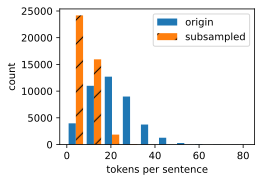

In [ ]:
# 绘制列表长度对的直方图
d2l.show_list_len_pair_hist(['origin', 'subsampled'], 
       'tokens per sentence','count', sentences, subsampled);
# 图例x轴代表每个句子长度是多少个单词
# 图例y轴代表当前句子长度的个数
# origin代表原来句子组中含有的句子呈正态分布。有很多很长的句子
# subsampled代表下采样后大多数句子只有几个单词。说明下采样去掉了很多单词
# 并且通过公式，可以知道下采样去掉的大都是高频单词。低频单词去掉的概率很低。

In [ ]:
def get_centers_and_contexts(corpus, max_window_size):
  """返回跳元模型中的中⼼词和上下⽂词"""
  centers, contexts = [], []
  for line in corpus:
    # 要形成“中⼼词-上下⽂词”对，每个句⼦⾄少需要有2个词
    if len(line) < 2:
      continue
    centers += line
    for i in range(len(line)): # 上下⽂窗⼝中间i
      # 上下文窗口是随机的
      window_size = random.randint(1, max_window_size)
      indices = list(range(max(0, i - window_size),min(len(line), i + 1 + window_size)))
      # 从上下⽂词中排除中⼼词
      indices.remove(i)
      contexts.append([line[idx] for idx in indices])
  return centers, contexts


In [ ]:
tiny_dataset = [list(range(7)), list(range(7, 10))]
print('数据集', tiny_dataset)
for center, context in zip(*get_centers_and_contexts(tiny_dataset, 2)):
  print('中⼼词', center, '的上下⽂词是', context)

数据集 [[0, 1, 2, 3, 4, 5, 6], [7, 8, 9]]
中⼼词 0 的上下⽂词是 [1, 2]
中⼼词 1 的上下⽂词是 [0, 2]
中⼼词 2 的上下⽂词是 [0, 1, 3, 4]
中⼼词 3 的上下⽂词是 [1, 2, 4, 5]
中⼼词 4 的上下⽂词是 [3, 5]
中⼼词 5 的上下⽂词是 [4, 6]
中⼼词 6 的上下⽂词是 [4, 5]
中⼼词 7 的上下⽂词是 [8]
中⼼词 8 的上下⽂词是 [7, 9]
中⼼词 9 的上下⽂词是 [8]


In [ ]:
# 将词元映射到它们在语料库中的索引
corpus = [vocab[line] for line in subsampled]
display(corpus[:3])
subsampled[:3]

[[], [2115, 145, 274, 406], [140, 5277, 3054, 1580]]

[[],
 ['join', 'board', 'director', 'nov.'],
 ['chairman', 'n.v.', 'dutch', 'publishing']]

In [ ]:
all_centers, all_contexts = get_centers_and_contexts(corpus, 5)
f'# “中⼼词-上下⽂词对”的数量: {sum([len(contexts) for contexts in all_contexts])}'


'# “中⼼词-上下⽂词对”的数量: 1504037'

#### 负采样
如果按照skip-gram模型进行任务训练。那么input是 中心词 target是 对应词对：

  例： the man loves his son
  
  input：loves 
  
  target：[the,man,his,son]

> 任务类型为多分类任务，但是中心词很多，并且需要判断对应的target更多，有可能达到几万甚至更多，则sofmmax极难完成当前任务。

&emsp;&emsp;所以这里word2vector转换了任务目标，使用负采样获取负样本（即如例子中[the,man,his,son]以外的单词）。并且改变任务目标——判断 输入是否为loves的上下文词。即

&emsp;&emsp;input1：loves 

&emsp;&emsp;input2：[the,man,his,son,***no,and,ok***] 

&emsp;&emsp;label：[1,1,1,1,***0,0,0***]

【注：加粗则是负样本】

&emsp;&emsp;这里word2vector转换任务目标为二分类任务。任务计算难度大大降低。

&emsp;&emsp;其中还有一些解决办法，比如hierarchical softmax。

In [ ]:
# 随机索引生成
class RandomGenerator:
  """
  根据n个采样权重在{1,...,n}中随机抽取
  根据输入的sampling_weights来随机的生成数据 这些数据从population中选取
  population的长度是sampling_weights的长度
  """
  def __init__(self, sampling_weights):
    # 生成一个index 1，2，3，4，5，6...
    self.population = list(range(1, len(sampling_weights) + 1))
    # 采样权重
    self.sampling_weights = sampling_weights
    # 采样候选数组
    self.candidates = []
    self.i = 0
  def draw(self):
    if self.i == len(self.candidates):
      # 缓存k个随机采样结果 这里就在生成需要的index
      self.candidates = random.choices(self.population, self.sampling_weights, k=10000)
      self.i = 0
    self.i += 1
    return self.candidates[self.i - 1]

In [ ]:
generator = RandomGenerator([2, 3, 4])
[generator.draw() for _ in range(10)]

[3, 2, 3, 1, 3, 3, 3, 1, 3, 3]

In [ ]:
# 负采样函数
def get_negatives(all_contexts, vocab, counter, K):
  """
  返回负采样中的噪声词
  all_contexts：所有的上下文
  vocab：词表
  counter：词频统计的dict
  k：每个中心词需要多少负采样词
  """
  # 索引为1、2、...（索引0是词表中排除的未知标记）
  # 根据单词出现频率的0.75次方进行权重计算
  sampling_weights = [counter[vocab.to_tokens(i)]**0.75
                    for i in range(1, len(vocab))]
  all_negatives = []
  # 输入权重list就可以得到index生成器generator
  generator = RandomGenerator(sampling_weights)

  for contexts in all_contexts:
    negatives = []
    while len(negatives) < len(contexts) * K:

      neg = generator.draw()
      # 噪声词不能是上下⽂词
      if neg not in contexts:
        negatives.append(neg)
    all_negatives.append(negatives)
  return all_negatives
all_negatives = get_negatives(all_contexts, vocab, counter, 5)


In [ ]:
def batchify(data):
  """返回带有负采样的跳元模型的⼩批量样本"""
  max_len = max(len(c) + len(n) for _, c, n in data)
  centers, contexts_negatives, masks, labels = [], [], [], []
  for center, context, negative in data:
    cur_len = len(context) + len(negative)
    centers += [center]
    contexts_negatives += [context + negative + [0] * (max_len - cur_len)]
    masks += [[1] * cur_len + [0] * (max_len - cur_len)]
    labels += [[1] * len(context) + [0] * (max_len - len(context))]
    
  return (torch.tensor(centers).reshape((-1, 1)), torch.tensor(
  contexts_negatives), torch.tensor(masks), torch.tensor(labels))

In [ ]:
# 综合前文的func
def load_data_ptb(batch_size, max_window_size, num_noise_words):
  """下载PTB数据集，然后将其加载到内存中"""
  num_workers = d2l.get_dataloader_workers()
  sentences = read_ptb()
  # 词表
  vocab = d2l.Vocab(sentences, min_freq=10)
  # 下采样和词频统计
  subsampled, counter = subsample(sentences, vocab)
  # 转换的语料
  corpus = [vocab[line] for line in subsampled]
  # 所有的中心词和上下文词
  all_centers, all_contexts = get_centers_and_contexts(corpus, max_window_size)
  # 所有的负采样词
  all_negatives = get_negatives(all_contexts, vocab, counter, num_noise_words)

  class PTBDataset(torch.utils.data.Dataset):
    def __init__(self, centers, contexts, negatives):
      assert len(centers) == len(contexts) == len(negatives)
      self.centers = centers
      self.contexts = contexts
      self.negatives = negatives
    def __getitem__(self, index):
      return (self.centers[index], self.contexts[index],self.negatives[index])
    def __len__(self):
      return len(self.centers)

  # 用PTBDataset封装
  dataset = PTBDataset(all_centers, all_contexts, all_negatives)
  # 转换为data_iter
  data_iter = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True,
                       collate_fn=batchify, num_workers=num_workers)
  return data_iter, vocab

In [ ]:
data_iter, vocab = load_data_ptb(5, 5, 5)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
names = ['centers', 'contexts_negatives', 'masks', 'labels']
tmp = None
for batch in data_iter:
  for name,data in zip(names,batch):
    print(name,":",data,data.shape)
    if name == "contexts_negatives":
      tmp = data
    # break
  break
# 

centers : tensor([[6050],
        [  11],
        [1358],
        [2392],
        [2840]]) torch.Size([5, 1])
contexts_negatives : tensor([[  37, 3192, 2584, 2892, 1121, 2056,  175,  126,   49, 1619,   42,  916,
          152,    8,    2, 4314,  905,  828,  128,  914, 1924, 3859, 1471,   49,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
        [ 268,    2,  717,  135, 2431, 3147, 4156,   96,  140,   79,    1,  287,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
        [2491, 2311,  245,  548,  325,   24,  607, 1249,    2,  201, 6227, 1016,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
        [ 103,  353,   92,  181,  579,  876, 3558,  235, 3308,  743,   23, 3500,
         1971, 2714,   91,   10,   12, 1580, 2464,  187,

In [ ]:
import math
import torch
from torch import nn
from d2l import torch as d2l
batch_size, max_window_size, num_noise_words = 512, 5, 5
data_iter, vocab = load_data_ptb(batch_size, max_window_size,num_noise_words)

In [ ]:
# 前向传播
def skip_gram(center, contexts_and_negatives, embed_v, embed_u):
  """
  num_embeddings: 词表个数
  embedding_dim: 词表维数
  embed = nn.Embedding(num_embeddings=20, embedding_dim=4)
  contexts_and_negatives: 上下文和负采样
  center: 中心词
  """
  v = embed_v(center)
  u = embed_u(contexts_and_negatives)
  # 例：输入shape center:(5,1) contexts_and_negatives:(5,36) 且embed_size = 4
  # 则 v为（5，1，4） u为（5，36，4） 
  # pred为 v与u.permute(0, 2, 1) 矩阵乘法后的结果
  # 其中 u.permute(0, 2, 1)的形状为 （5，4，36）
  pred = torch.bmm(v, u.permute(0, 2, 1))
  return pred

In [ ]:
class SigmoidBCELoss(nn.Module):
  # 带掩码的⼆元交叉熵损失
  def __init__(self):
    super().__init__()
  def forward(self, inputs, target, mask=None):
    out = nn.functional.binary_cross_entropy_with_logits(inputs, target, weight=mask, reduction="none")
    return out.mean(dim=1)
loss = SigmoidBCELoss()

In [ ]:
embed_size = 50
net = nn.Sequential(
      nn.Embedding(num_embeddings=len(vocab),embedding_dim=embed_size),
      nn.Embedding(num_embeddings=len(vocab),embedding_dim=embed_size)
    )

In [ ]:
def train(net, data_iter, lr, num_epochs,loss, device=d2l.try_gpu()):
  def init_weights(m):
    if type(m) == nn.Embedding:
      nn.init.xavier_uniform_(m.weight)
  net.apply(init_weights)

  net = net.to(device)
  optimizer = torch.optim.Adam(net.parameters(), lr=lr)
  animator = d2l.Animator(xlabel='epoch', ylabel='loss',
  xlim=[1, num_epochs])
  # 规范化的损失之和，规范化的损失数
  metric = d2l.Accumulator(2)
  for epoch in range(num_epochs):
    # 计时器和batches
    timer, num_batches = d2l.Timer(), len(data_iter)
    for i, batch in enumerate(data_iter):
      # 常规的训练过程
      optimizer.zero_grad()
      center, context_negative, mask, label = [
      data.to(device) for data in batch]
      
      pred = skip_gram(center, context_negative, net[0], net[1])
      # 因为有掩码，这里是掩码训练loss的实现
      l = (loss(pred.reshape(label.shape).float(), label.float(), mask)/mask.sum(axis=1) * mask.shape[1])
      l.sum().backward()
      optimizer.step()
      # 更新图片
      metric.add(l.sum(), l.numel())
      if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
        animator.add(epoch + (i + 1) / num_batches,(metric[0] / metric[1],))
  print(f'loss {metric[0] / metric[1]:.3f}, 'f'{metric[1] / timer.stop():.1f} tokens/sec on {str(device)}')


loss 0.429, 208764.0 tokens/sec on cuda:0


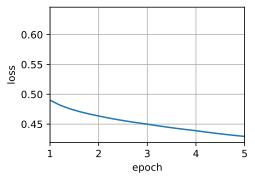

In [ ]:
lr, num_epochs = 0.002, 5
train(net, data_iter, lr, num_epochs, loss)

In [ ]:
def get_similar_tokens(query_token, k, embed):
  W = embed.weight.data
  x = W[vocab[query_token]]
  # 计算余弦相似性。增加1e-9以获得数值稳定性
  cos = torch.mv(W, x) / torch.sqrt(torch.sum(W * W, dim=1) *
  torch.sum(x * x) + 1e-9)
  topk = torch.topk(cos, k=k+1)[1].cpu().numpy().astype('int32')
  for i in topk[1:]: # 删除输⼊词
    print(f'cosine sim={float(cos[i]):.3f}: {vocab.to_tokens(i)}')
get_similar_tokens('chip', 3, net[0])


cosine sim=0.813: intel
cosine sim=0.721: workstations
cosine sim=0.716: disk


### bert
- bert的输入

1）在序列tokens中把分割token（[SEP]）插入到每个句子后，以分开不同的句子tokens。

2）为每一个token表征都添加一个可学习的分割embedding来指示其属于句子A还是句子B。
<div align=center> 
<img src="https://pic1.zhimg.com/v2-a12ee6f717cc8312c43d140eb173def8_r.jpg"/>
</div>
上面提到了BERT的输入为每一个token对应的表征，实际上该表征是由三部分组成的，分别是对应的token，分割和位置 embeddings
<div align=center> 
<img src="https://pic1.zhimg.com/v2-ee823df66560850baa34128af76a6334_r.jpg"/>
</div>

- BERT构建了两个预训练任务，分别是Masked Language Model和Next Sentence Prediction。

- bert的输出

C为分类token（[CLS]）对应最后一个Transformer的输出， $T_i$则代表其他token对应最后一个Transformer的输出。对于一些token级别的任务（如，序列标注和问答任务），就把 输入到额外的输出层中进行预测。对于一些句子级别的任务（如，自然语言推断和情感分类任务），就把C输入到额外的输出层中，这里也就解释了为什么要在每一个token序列前都要插入特定的分类token。
<div align=center> 
<img src="https://pic3.zhimg.com/80/v2-f0618dc2c2f62bd8d71c2195947be1d6_720w.jpg"/>
</div>

#### encoder块定义

In [ ]:
class BERTEncoder(nn.Module):
  """BERT编码器实现"""
  def __init__(self, vocab_size, num_hiddens, norm_shape, ffn_num_input,
          ffn_num_hiddens, num_heads, num_layers, dropout,
          max_len=1000, key_size=768, query_size=768, value_size=768,
          **kwargs):
    super(BERTEncoder, self).__init__(**kwargs)
    self.token_embedding = nn.Embedding(vocab_size, num_hiddens)
    self.segment_embedding = nn.Embedding(2, num_hiddens)
    # 在BERT中，位置嵌⼊是可学习的，因此我们创建⼀个⾜够⻓的位置嵌⼊参数
    self.pos_embedding = nn.Parameter(torch.randn(1, max_len,
    num_hiddens))
    # 堆叠
    self.blks = nn.Sequential()
    for i in range(num_layers):
      self.blks.add_module(f"{i}", d2l.EncoderBlock(
      key_size, query_size, value_size, num_hiddens, norm_shape,
      ffn_num_input, ffn_num_hiddens, num_heads, dropout, True))
  def forward(self, tokens, segments, valid_lens):
    # 在以下代码段中，X的形状保持不变：（批量⼤⼩，最⼤序列⻓度，num_hiddens）
    # 三个embedding相加
    X = self.token_embedding(tokens) + self.segment_embedding(segments)
    X = X + self.pos_embedding.data[:, :X.shape[1], :]
    # 再在所有block中进行训练
    for blk in self.blks:
      X = blk(X, valid_lens)
    return X

In [ ]:
vocab_size, num_hiddens, ffn_num_hiddens, num_heads = 10000, 768, 1024, 4
norm_shape, ffn_num_input, num_layers, dropout = [768], 768, 2, 0.2
encoder = BERTEncoder(vocab_size, num_hiddens, norm_shape, ffn_num_input,ffn_num_hiddens, num_heads, num_layers, dropout)
"""
将tokens定义为⻓度为8的2个输⼊序列，其中每个词元是词表的索引。使⽤输
⼊tokens的BERTEncoder的前向推断返回编码结果,其中每个词元由向量表⽰，其⻓度由超参
数num_hiddens定义。此超参数通常称为Transformer编码器的隐藏⼤小（隐藏单元数）。
"""
tokens = torch.randint(0, vocab_size, (2, 8))
print(tokens)
segments = torch.tensor([[0, 0, 0, 0, 1, 1, 1, 1], [0, 0, 0, 1, 1, 1, 1, 1]])
encoded_X = encoder(tokens, segments, None)
encoded_X.shape

tensor([[ 494, 9828, 1023, 7761, 9510, 5052, 3690, 4687],
        [2855, 2629, 3319, 8461, 9122, 2673, 8691, 1581]])


torch.Size([2, 8, 768])

#### 子任务定义

In [ ]:
# 子任务定义
class MaskLM(nn.Module):
  """BERT的掩蔽语⾔模型任务"""
  def __init__(self, vocab_size, num_hiddens, num_inputs=768, **kwargs):
    super(MaskLM, self).__init__(**kwargs)
    self.mlp = nn.Sequential(nn.Linear(num_inputs, num_hiddens),
                  nn.ReLU(),
                  nn.LayerNorm(num_hiddens),
                  nn.Linear(num_hiddens, vocab_size))

  def forward(self, X, pred_positions):
    num_pred_positions = pred_positions.shape[1]
    pred_positions = pred_positions.reshape(-1)
    batch_size = X.shape[0]
    # 假设batch_size=2，num_pred_positions=3
    # 那么batch_idx是np.array（[0,1]）
    batch_idx = torch.arange(0, batch_size)
    # repeat_interleave后为np.array（[0,0,0,1,1,1]）
    # 同时也应该为[0,0,0,1,1,1]
    batch_idx = torch.repeat_interleave(batch_idx, num_pred_positions)
    masked_X = X[batch_idx, pred_positions]
    
    masked_X = masked_X.reshape((batch_size, num_pred_positions, -1))
    mlm_Y_hat = self.mlp(masked_X)
    return mlm_Y_hat

In [ ]:
print(encoded_X[[0,0,0,1,1,1],[1, 5, 2, 6, 1, 5]].shape)
encoded_X[[0,0,0,1,1,1],[1, 5, 2, 6, 1, 5]].reshape((2, 3, -1)).shape

torch.Size([6, 768])


torch.Size([2, 3, 768])

In [ ]:
"""
我们将mlm_positions定义为在encoded_X的任⼀输⼊序列中预测的3个指⽰。
mlm的前向推断返回encoded_X的所有掩蔽位置mlm_positions处的预测结
果mlm_Y_hat。对于每个预测，结果的⼤小等于词表的⼤小。
"""
mlm = MaskLM(vocab_size, num_hiddens)
mlm_positions = torch.tensor([[1, 5, 2], [6, 1, 5]])
mlm_Y_hat = mlm(encoded_X, mlm_positions)
print(mlm_Y_hat.shape)
"""
通过掩码下的预测词元mlm_Y的真实标签mlm_Y_hat，
我们可以计算在BERT预训练中的遮蔽语⾔模型任务
的交叉熵损失。
"""
mlm_Y = torch.tensor([[7, 8, 9], [10, 20, 30]])
loss = nn.CrossEntropyLoss(reduction='none')
mlm_l = loss(mlm_Y_hat.reshape((-1, vocab_size)), mlm_Y.reshape(-1))
mlm_l.shape

torch.Size([2, 3, 10000])


torch.Size([6])

In [ ]:
class NextSentencePred(nn.Module):
  """BERT的下⼀句预测任务"""
  def __init__(self, num_inputs, **kwargs):
    super(NextSentencePred, self).__init__(**kwargs)
    self.output = nn.Linear(num_inputs, 2)
  def forward(self, X):
    # X的形状：(batchsize,num_hiddens)
    return self.output(X)


In [ ]:
encoded_X.shape[-1]

768

In [ ]:
encoded_X

tensor([[[ 1.0300,  0.3184,  0.1359,  ..., -0.7681,  1.8320,  0.1710],
         [-0.1815,  0.1572, -0.7951,  ...,  0.2367,  0.4435,  1.4045],
         [-0.8095,  1.2352,  0.4881,  ..., -0.4655,  0.9953,  1.4593],
         ...,
         [ 0.4617, -0.7007, -0.2722,  ..., -0.6532,  1.9664,  0.0795],
         [-0.3651, -2.0006, -2.3630,  ..., -1.1384,  1.0908, -0.6801],
         [-0.3488,  0.3627, -1.8713,  ..., -0.5273,  0.9861, -0.7218]],

        [[ 0.6210,  0.3885,  0.3080,  ..., -0.6704,  2.2712,  1.6621],
         [ 0.3867, -0.4777, -0.4435,  ..., -0.8720,  0.5934,  1.1697],
         [-0.1471,  1.1895, -0.4421,  ..., -0.1049,  0.6449,  0.7023],
         ...,
         [ 0.3638, -0.5291,  0.2298,  ..., -0.5214,  1.9833,  0.2338],
         [-0.3286, -2.5310, -2.8125,  ..., -0.7180,  0.0477,  0.5790],
         [ 0.6858, -0.6276, -1.3450,  ...,  0.9266,  0.9094, -0.4732]]],
       grad_fn=<NativeLayerNormBackward0>)

In [ ]:
encoded_X = torch.flatten(encoded_X, start_dim=1)
# NSP的输⼊形状:(batchsize，num_hiddens)
nsp = NextSentencePred(encoded_X.shape[-1])
nsp_Y_hat = nsp(encoded_X)
print(nsp_Y_hat)

nsp_y = torch.tensor([0, 1])
nsp_l = loss(nsp_Y_hat, nsp_y)
nsp_l.shape


tensor([[-0.4331,  0.5601],
        [-0.0136, -0.3232]], grad_fn=<AddmmBackward0>)


torch.Size([2])

#### 模型整合

In [ ]:
class BERTModel(nn.Module):
  """BERT模型"""
  def __init__(self, vocab_size, num_hiddens, norm_shape, ffn_num_input,
        ffn_num_hiddens, num_heads, num_layers, dropout,
        max_len=1000, key_size=768, query_size=768, value_size=768,
        hid_in_features=768, mlm_in_features=768,
        nsp_in_features=768):
    super(BERTModel, self).__init__()
    self.encoder = BERTEncoder(vocab_size, num_hiddens, norm_shape,
                  ffn_num_input, ffn_num_hiddens, num_heads, num_layers,
                  dropout, max_len=max_len, key_size=key_size,
                  query_size=query_size, value_size=value_size)
    self.hidden = nn.Sequential(nn.Linear(hid_in_features, num_hiddens),nn.Tanh())
    self.mlm = MaskLM(vocab_size, num_hiddens, mlm_in_features)
    self.nsp = NextSentencePred(nsp_in_features)
  def forward(self, tokens, segments, valid_lens=None,pred_positions=None):
    encoded_X = self.encoder(tokens, segments, valid_lens)
    if pred_positions is not None:
      mlm_Y_hat = self.mlm(encoded_X, pred_positions)
    else:
      mlm_Y_hat = None
    # ⽤于下⼀句预测的多层感知机分类器的隐藏层，0是“<cls>”标记的索引
    nsp_Y_hat = self.nsp(self.hidden(encoded_X[:, 0, :]))
    return encoded_X, mlm_Y_hat, nsp_Y_hat

In [ ]:
batch_size, max_len = 512, 64
train_iter, vocab = d2l.load_data_wiki(batch_size, max_len)

net = d2l.BERTModel(len(vocab), num_hiddens=128, norm_shape=[128],
          ffn_num_input=128, ffn_num_hiddens=256, num_heads=2,
          num_layers=2, dropout=0.2, key_size=128, query_size=128,
          value_size=128, hid_in_features=128, mlm_in_features=128,
          nsp_in_features=128)
devices = d2l.try_all_gpus()
loss = nn.CrossEntropyLoss()

#### loss计算

In [ ]:
def _get_batch_loss_bert(net, loss, vocab_size, tokens_X,
            segments_X, valid_lens_x,
            pred_positions_X, mlm_weights_X,
            mlm_Y, nsp_y):
  # 前向传播
  _, mlm_Y_hat, nsp_Y_hat = net(tokens_X, segments_X,
                    valid_lens_x.reshape(-1),
                    pred_positions_X)
  # 计算遮蔽语⾔模型损失
  mlm_l = loss(mlm_Y_hat.reshape(-1, vocab_size), mlm_Y.reshape(-1)) *\
  mlm_weights_X.reshape(-1, 1)
  mlm_l = mlm_l.sum() / (mlm_weights_X.sum() + 1e-8)
  # 计算下⼀句⼦预测任务的损失
  nsp_l = loss(nsp_Y_hat, nsp_y)
  l = mlm_l + nsp_l
  return mlm_l, nsp_l, l

#### 训练

In [ ]:
def train_bert(train_iter, net, loss, vocab_size, devices, num_steps):
  net = nn.DataParallel(net, device_ids=devices).to(devices[0])
  trainer = torch.optim.Adam(net.parameters(), lr=0.01)
  step, timer = 0, d2l.Timer()
  animator = d2l.Animator(xlabel='step', ylabel='loss',
  xlim=[1, num_steps], legend=['mlm', 'nsp'])
  # 遮蔽语⾔模型损失的和，下⼀句预测任务损失的和，句⼦对的数量，计数
  metric = d2l.Accumulator(4)
  num_steps_reached = False
  while step < num_steps and not num_steps_reached:
    for tokens_X, segments_X, valid_lens_x, pred_positions_X, mlm_weights_X, mlm_Y, nsp_y in train_iter:
      # 定义变量
      tokens_X = tokens_X.to(devices[0])
      segments_X = segments_X.to(devices[0])
      valid_lens_x = valid_lens_x.to(devices[0])
      pred_positions_X = pred_positions_X.to(devices[0])
      mlm_weights_X = mlm_weights_X.to(devices[0])
      mlm_Y, nsp_y = mlm_Y.to(devices[0]), nsp_y.to(devices[0])

      # 训练
      trainer.zero_grad()
      # 计时
      timer.start()
      # 计算loss
      mlm_l, nsp_l, l = _get_batch_loss_bert(net, loss, vocab_size, tokens_X, segments_X, valid_lens_x,
                            pred_positions_X, mlm_weights_X, mlm_Y, nsp_y)
      l.backward()
      trainer.step()
      # 画图
      metric.add(mlm_l, nsp_l, tokens_X.shape[0], 1)
      timer.stop()
      animator.add(step + 1,(metric[0] / metric[3], metric[1] / metric[3]))

      step += 1
      if step == num_steps:
        num_steps_reached = True
      break
  print(f'MLM loss {metric[0] / metric[3]:.3f}, '
      f'NSP loss {metric[1] / metric[3]:.3f}')
  print(f'{metric[2] / timer.sum():.1f} sentence pairs/sec on '
      f'{str(devices)}')

MLM loss 5.749, NSP loss 0.790
4550.1 sentence pairs/sec on [device(type='cuda', index=0)]


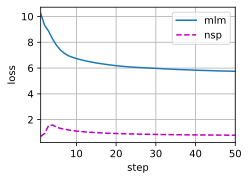

In [ ]:
train_bert(train_iter, net, loss, len(vocab), devices, 50)

In [ ]:
# 用bert表示文本
def get_bert_encoding(net, tokens_a, tokens_b=None):
  tokens, segments = d2l.get_tokens_and_segments(tokens_a, tokens_b)
  token_ids = torch.tensor(vocab[tokens], device=devices[0]).unsqueeze(0)
  segments = torch.tensor(segments, device=devices[0]).unsqueeze(0)
  valid_len = torch.tensor(len(tokens), device=devices[0]).unsqueeze(0)
  encoded_X, _, _ = net(token_ids, segments, valid_len)
  return encoded_X

In [ ]:
tokens_a = ['a', 'crane', 'is', 'flying']
encoded_text = get_bert_encoding(net, tokens_a)
# 词元：'<cls>','a','crane','is','flying','<sep>'
encoded_text_cls = encoded_text[:, 0, :]
encoded_text_crane = encoded_text[:, 2, :]
encoded_text.shape, encoded_text_cls.shape, encoded_text_crane[0][:3]


(torch.Size([1, 6, 128]),
 torch.Size([1, 128]),
 tensor([-0.2891,  0.3696, -0.0006], device='cuda:0', grad_fn=<SliceBackward0>))

In [ ]:
tokens_a, tokens_b = ['a', 'crane', 'driver', 'came'], ['he', 'just', 'left']
encoded_pair = get_bert_encoding(net, tokens_a, tokens_b)
# 词元：'<cls>','a','crane','driver','came','<sep>','he','just','left','<sep>'
encoded_pair_cls = encoded_pair[:, 0, :]
encoded_pair_crane = encoded_pair[:, 2, :]
encoded_pair.shape, encoded_pair_cls.shape, encoded_pair_crane[0][:3]


(torch.Size([1, 10, 128]),
 torch.Size([1, 128]),
 tensor([-0.2346,  0.2648, -0.0431], device='cuda:0', grad_fn=<SliceBackward0>))

## 下游任务实现

### glove微调lstm实现情感分析

In [ ]:
import torch
from torch import nn
from d2l import torch as d2l
batch_size = 64
train_iter, test_iter, vocab = d2l.load_data_imdb(batch_size)

In [ ]:
class BiRNN(nn.Module):
  def __init__(self, vocab_size, embed_size, num_hiddens,
    num_layers, **kwargs):
    super(BiRNN, self).__init__(**kwargs)
    self.embedding = nn.Embedding(vocab_size, embed_size)
    # 将bidirectional设置为True以获取双向循环神经⽹络
    self.encoder = nn.LSTM(embed_size, num_hiddens, num_layers=num_layers,
    bidirectional=True)
    self.decoder = nn.Linear(4 * num_hiddens, 2)
  def forward(self, inputs):
    # inputs的形状是（批量⼤⼩，时间步数）
    # 因为⻓短期记忆⽹络要求其输⼊的第⼀个维度是时间维，
    # 所以在获得词元表⽰之前，输⼊会被转置。
    # 输出形状为（时间步数，批量⼤⼩，词向量维度）
    embeddings = self.embedding(inputs.T)
    self.encoder.flatten_parameters()
    # 返回上⼀个隐藏层在不同时间步的隐状态，
    # outputs的形状是（时间步数，批量⼤⼩，2*隐藏单元数）
    outputs, _ = self.encoder(embeddings)
    # 连结初始和最终时间步的隐状态，作为全连接层的输⼊，
    # 其形状为（批量⼤⼩，4*隐藏单元数）
    encoding = torch.cat((outputs[0], outputs[-1]), dim=1)
    outs = self.decoder(encoding)
    return outs

In [ ]:
embed_size, num_hiddens, num_layers = 100, 100, 2
devices = d2l.try_all_gpus()
net = BiRNN(len(vocab), embed_size, num_hiddens, num_layers)

In [ ]:
def init_weights(m):
  if type(m) == nn.Linear:
    nn.init.xavier_uniform_(m.weight)
  if type(m) == nn.LSTM:
    for param in m._flat_weights_names:
      if "weight" in param:
        nn.init.xavier_uniform_(m._parameters[param])
net.apply(init_weights);

In [ ]:
glove_embedding = d2l.TokenEmbedding('glove.6b.100d')
embeds = glove_embedding[vocab.idx_to_token]
embeds.shape

torch.Size([49346, 100])

In [ ]:
net.embedding.weight.data.copy_(embeds)
net.embedding.weight.requires_grad = False

loss 0.261, train acc 0.894, test acc 0.856
1051.6 examples/sec on [device(type='cuda', index=0)]


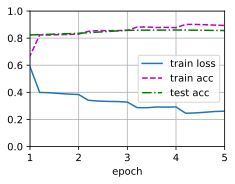

In [ ]:
lr, num_epochs = 0.01, 5
trainer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction="none")
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs,devices)

In [ ]:
def predict_sentiment(net, vocab, sequence):
  """预测⽂本序列的情感"""
  sequence = torch.tensor(vocab[sequence.split()], device=d2l.try_gpu())
  label = torch.argmax(net(sequence.reshape(1, -1)), dim=1)
  return 'positive' if label == 1 else 'negative'

In [ ]:
predict_sentiment(net, vocab, 'this movie is so great')

'positive'

In [ ]:
predict_sentiment(net, vocab, 'this movie is so bad')

'negative'

### bert微调实现语义推断

In [2]:
import os
import re
import torch
from torch import nn
from d2l import torch as d2l
d2l.DATA_HUB['SNLI'] = (
  'https://nlp.stanford.edu/projects/snli/snli_1.0.zip',
  '9fcde07509c7e87ec61c640c1b2753d9041758e4')
data_dir = d2l.download_extract('SNLI')

def read_snli(data_dir, is_train):
  """将SNLI数据集解析为前提、假设和标签"""
  def extract_text(s):
    # 删除我们不会使⽤的信息
    s = re.sub('\\(', '', s)
    s = re.sub('\\)', '', s)
    # ⽤⼀个空格替换两个或多个连续的空格
    s = re.sub('\\s{2,}', ' ', s)
    return s.strip()
  label_set = {'entailment': 0, 'contradiction': 1, 'neutral': 2}
  file_name = os.path.join(data_dir, 'snli_1.0_train.txt'
  if is_train else 'snli_1.0_test.txt')
  with open(file_name, 'r') as f:
    rows = [row.split('\t') for row in f.readlines()[1:]]
  premises = [extract_text(row[1]) for row in rows if row[0] in label_set]
  hypotheses = [extract_text(row[2]) for row in rows if row[0] in label_set]
  labels = [label_set[row[0]] for row in rows if row[0] in label_set]
  return premises, hypotheses, labels

In [3]:
train_data = read_snli(data_dir, is_train=True)
for x0, x1, y in zip(train_data[0][:3], train_data[1][:3], train_data[2][:3]):
  print('前提：', x0)
  print('假设：', x1)
  print('标签：', y)


前提： A person on a horse jumps over a broken down airplane .
假设： A person is training his horse for a competition .
标签： 2
前提： A person on a horse jumps over a broken down airplane .
假设： A person is at a diner , ordering an omelette .
标签： 1
前提： A person on a horse jumps over a broken down airplane .
假设： A person is outdoors , on a horse .
标签： 0


In [4]:
import multiprocessing
class SNLIBERTDataset(torch.utils.data.Dataset):
  def __init__(self, dataset, max_len, vocab=None):
    all_premise_hypothesis_tokens = [[p_tokens, h_tokens] for p_tokens, h_tokens in zip(
                      *[d2l.tokenize([s.lower() for s in sentences])
                      for sentences in dataset[:2]])]
    self.labels = torch.tensor(dataset[2])
    self.vocab = vocab
    self.max_len = max_len
    (self.all_token_ids, self.all_segments,
    self.valid_lens) = self._preprocess(all_premise_hypothesis_tokens)
    print('read ' + str(len(self.all_token_ids)) + ' examples')
  def _preprocess(self, all_premise_hypothesis_tokens):
    pool = multiprocessing.Pool(4) # 使⽤4个进程
    out = pool.map(self._mp_worker, all_premise_hypothesis_tokens)
    all_token_ids = [token_ids for token_ids, segments, valid_len in out]
    all_segments = [segments for token_ids, segments, valid_len in out]
    valid_lens = [valid_len for token_ids, segments, valid_len in out]
    return (torch.tensor(all_token_ids, dtype=torch.long),
          torch.tensor(all_segments, dtype=torch.long),
          torch.tensor(valid_lens))
  def _mp_worker(self, premise_hypothesis_tokens):
    p_tokens, h_tokens = premise_hypothesis_tokens
    self._truncate_pair_of_tokens(p_tokens, h_tokens)
    tokens, segments = d2l.get_tokens_and_segments(p_tokens, h_tokens)
    token_ids = self.vocab[tokens] + [self.vocab['<pad>']] \
            * (self.max_len - len(tokens))
    segments = segments + [0] * (self.max_len - len(segments))
    valid_len = len(tokens)
    return token_ids, segments, valid_len
  def _truncate_pair_of_tokens(self, p_tokens, h_tokens):
  # 为BERT输⼊中的'<CLS>'、'<SEP>'和'<SEP>'词元保留位置
    while len(p_tokens) + len(h_tokens) > self.max_len - 3:
      if len(p_tokens) > len(h_tokens):
        p_tokens.pop()
      else:
        h_tokens.pop()
  def __getitem__(self, idx):
    return (self.all_token_ids[idx], self.all_segments[idx],self.valid_lens[idx]), self.labels[idx]
  def __len__(self):
    return len(self.all_token_ids)


In [5]:
import json
d2l.DATA_HUB['bert.base'] = (d2l.DATA_URL + 'bert.base.torch.zip',
'225d66f04cae318b841a13d32af3acc165f253ac')
d2l.DATA_HUB['bert.small'] = (d2l.DATA_URL + 'bert.small.torch.zip',
'c72329e68a732bef0452e4b96a1c341c8910f81f')

def load_pretrained_model(pretrained_model, num_hiddens, ffn_num_hiddens,
num_heads, num_layers, dropout, max_len, devices):
  data_dir = d2l.download_extract(pretrained_model)
  # 定义空词表以加载预定义词表
  vocab = d2l.Vocab()
  vocab.idx_to_token = json.load(open(os.path.join(data_dir,'vocab.json')))
  vocab.token_to_idx = {token: idx for idx, token in enumerate(vocab.idx_to_token)}

  bert = d2l.BERTModel(len(vocab), num_hiddens, norm_shape=[256],
              ffn_num_input=256, ffn_num_hiddens=ffn_num_hiddens,
              num_heads=4, num_layers=2, dropout=0.2,
              max_len=max_len, key_size=256, query_size=256,
              value_size=256, hid_in_features=256,
              mlm_in_features=256, nsp_in_features=256)
  
  # 加载预训练BERT参数
  bert.load_state_dict(torch.load(os.path.join(data_dir,'pretrained.params')))
  return bert, vocab

In [6]:
devices = d2l.try_all_gpus()
bert, vocab = load_pretrained_model('bert.small', num_hiddens=256, ffn_num_hiddens=512, num_heads=4,
                  num_layers=2, dropout=0.1, max_len=512, devices=devices)

In [7]:
batch_size, max_len, num_workers = 512, 128, 2
data_dir = d2l.download_extract('SNLI')
train_set = SNLIBERTDataset(d2l.read_snli(data_dir, True), max_len, vocab)
test_set = SNLIBERTDataset(d2l.read_snli(data_dir, False), max_len, vocab)
train_iter = torch.utils.data.DataLoader(train_set, batch_size, shuffle=True,
                      num_workers=num_workers)
test_iter = torch.utils.data.DataLoader(test_set, batch_size,
                      num_workers=num_workers)

read 549367 examples
read 9824 examples


In [8]:
class BERTClassifier(nn.Module):
  def __init__(self, bert):
    super(BERTClassifier, self).__init__()
    self.encoder = bert.encoder
    self.hidden = bert.hidden
    
    self.output = nn.Linear(256, 3)

  def forward(self, inputs):
    tokens_X, segments_X, valid_lens_x = inputs
    encoded_X = self.encoder(tokens_X, segments_X, valid_lens_x)
    return self.output(self.hidden(encoded_X[:, 0, :]))

In [9]:
net = BERTClassifier(bert)


loss 0.522, train acc 0.790, test acc 0.777
2497.2 examples/sec on [device(type='cuda', index=0)]


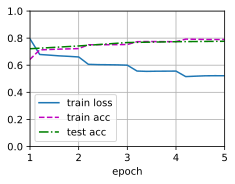

In [10]:
lr, num_epochs = 1e-4, 5
trainer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction='none')
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs,devices)